# Time series forecasting with LSTM

In this notebook we shall see how we can use LSTM (Long Short Term Memory), a deep neural network architecture to forecast timeseries data.

The example shown in this workbook is taken from this [link](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/).

## Read and preprocess the data

### Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

### Reading the dataset

In [2]:
dataset = pd.read_csv("./airline_passengers.csv", parse_dates=True)

In [3]:
dataset.head()

,Month,Thousands of Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Month                    144 non-null    object
 1   Thousands of Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


### Converting the month column into pandas datetime format

In [5]:
dataset['Month'] = pd.to_datetime(dataset['Month'])

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Month                    144 non-null    datetime64[ns]
 1   Thousands of Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


In [7]:
dataset.set_index(keys='Month',inplace=True) # reindex the dataframe with 'Month' columns

### Plot the data

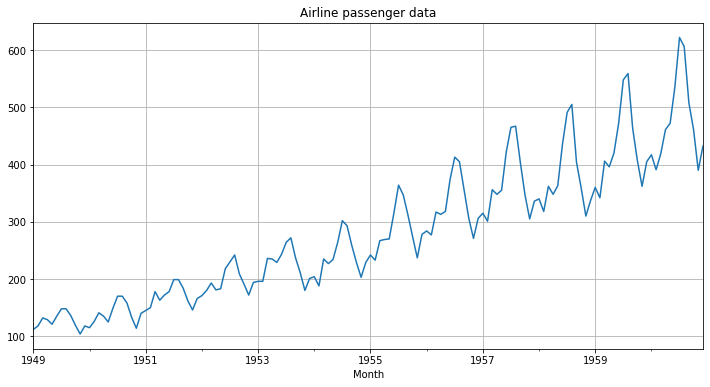

In [8]:
dataset.plot(figsize=(12,6),title='Airline passenger data',legend=False)
plt.grid()
plt.show()

### Normalize the dataset

In [9]:
from sklearn.preprocessing import MinMaxScaler

In [10]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset_normalized = scaler.fit_transform(dataset)

In [11]:
dataset_normalized.shape

(144, 1)

## LSTM Network for Regression

You can phrase the problem as a regression problem.

That is, given the number of passengers (in units of thousands) this month, what is the number of passengers next month?

You can write a simple function to convert the single column of data into a two-column dataset: the first column containing this month’s (t) passenger count and the second column containing next month’s (t+1) passenger count to be predicted.

Before you start, let’s first import all the functions and classes you will use. This assumes a working SciPy environment with the Keras deep learning library installed.

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.metrics import mean_squared_error

### Split the dataset into train and test

In [19]:
train_ratio = 0.75
train_size = int(len(dataset_normalized)*train_ratio)
test_size = len(dataset_normalized) - train_size

In [20]:
train, test = dataset_normalized[:train_size, :], dataset_normalized[train_size:, :]

In [21]:
train.shape, test.shape

((108, 1), (36, 1))

Now, you can define a function to create a new dataset, as described above.

The function takes two arguments: the dataset, which is a NumPy array you want to convert into a dataset, and the look_back, which is the number of previous time steps to use as input variables to predict the next time period—in this case, defaulted to 1.

This default will create a dataset where X is the number of passengers at a given time (t), and Y is the number of passengers at the next time (t + 1).

It can be configured by constructing a differently shaped dataset in the next section.

In [22]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX).reshape(-1,1), np.array(dataY).reshape(-1,1)

Let’s take a look at the effect of this function on the first rows of the dataset (shown in the unnormalized form for clarity).

In [23]:
X, Y = create_dataset(dataset.values)

In [24]:
pd.DataFrame(np.concatenate((X,Y), axis=1), columns=['X','Y'])

,X,Y
0,112,118
1,118,132
2,132,129
3,129,121
4,121,135
...,...,...
137,535,622
138,622,606
139,606,508
140,508,461


Let’s use this function to prepare the train and test datasets for modeling.

In [25]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

The LSTM network expects the input data (X) to be provided with a specific array structure in the form of [samples, time steps, features].

Currently, the data is in the form of [samples, features], and you are framing the problem as one time step for each sample. You can transform the prepared train and test input data into the expected structure using numpy.reshape() as follows:

In [26]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

You are now ready to design and fit your LSTM network for this problem.

The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons, and an output layer that makes a single value prediction. The default sigmoid activation function is used for the LSTM blocks. The network is trained for 100 epochs, and a batch size of 1 is used.

In [27]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
106/106 - 3s - loss: 0.0597 - 3s/epoch - 28ms/step
Epoch 2/100
106/106 - 0s - loss: 0.0283 - 255ms/epoch - 2ms/step
Epoch 3/100
106/106 - 0s - loss: 0.0212 - 269ms/epoch - 3ms/step
Epoch 4/100
106/106 - 0s - loss: 0.0188 - 262ms/epoch - 2ms/step
Epoch 5/100
106/106 - 0s - loss: 0.0169 - 274ms/epoch - 3ms/step
Epoch 6/100
106/106 - 0s - loss: 0.0150 - 259ms/epoch - 2ms/step
Epoch 7/100
106/106 - 0s - loss: 0.0133 - 270ms/epoch - 3ms/step
Epoch 8/100
106/106 - 0s - loss: 0.0117 - 271ms/epoch - 3ms/step
Epoch 9/100
106/106 - 0s - loss: 0.0100 - 258ms/epoch - 2ms/step
Epoch 10/100
106/106 - 0s - loss: 0.0086 - 254ms/epoch - 2ms/step
Epoch 11/100
106/106 - 0s - loss: 0.0073 - 268ms/epoch - 3ms/step
Epoch 12/100
106/106 - 0s - loss: 0.0061 - 264ms/epoch - 2ms/step
Epoch 13/100
106/106 - 0s - loss: 0.0052 - 259ms/epoch - 2ms/step
Epoch 14/100
106/106 - 0s - loss: 0.0044 - 268ms/epoch - 3ms/step
Epoch 15/100
106/106 - 0s - loss: 0.0039 - 250ms/epoch - 2ms/step
Epoch 16/100
106/106 

Once the model is fit, you can estimate the performance of the model on the train and test datasets. This will give you a point of comparison for new models.

Note that you will invert the predictions before calculating error scores to ensure that performance is reported in the same units as the original data (thousands of passengers per month).

In [28]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

2/2 [==============================] - 0s 4ms/step


In [29]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

In [30]:
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY.flatten(), trainPredict.flatten()))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY.flatten(), testPredict.flatten()))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 25.40 RMSE
Test Score: 49.61 RMSE


Finally, you can generate predictions using the model for both the train and test dataset to get a visual indication of the skill of the model.

Because of how the dataset was prepared, you must shift the predictions so that they align on the x-axis with the original dataset. Once prepared, the data is plotted, showing the original dataset, the predictions for the training dataset, and the predictions on the unseen test dataset.

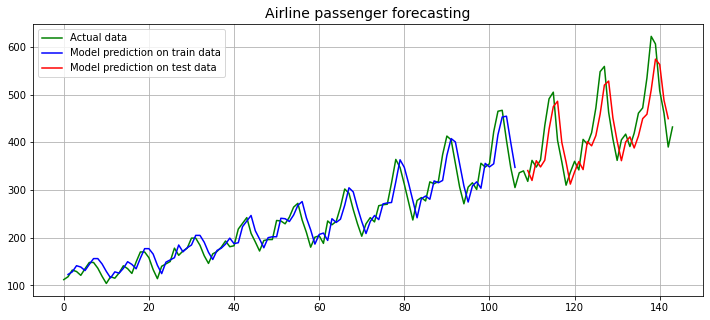

In [31]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset, dtype='float')
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset, dtype='float')
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.figure(figsize=(12,5))
plt.plot(dataset.values, label='Actual data',c='g')
plt.plot(trainPredictPlot, label='Model prediction on train data',c='b')
plt.plot(testPredictPlot, label='Model prediction on test data',c='r')
plt.grid()
plt.title("Airline passenger forecasting", fontsize=14)
plt.legend()
plt.show()

You can see that the model did an excellent job of fitting both the training dataset and performed well in the test datasets.